# Predicción de ventas

Los datos entregados corresponden a ventas realizadas en una única tienda Jumbo en el período que comprende desde el 2021-01-02 hasta el 2022-01-09. El objetivo final de la evaluación es realizar una predicción diaria de las ventas de la semana del 17 al 23 de Enero del 2022, es decir, un valor para cada día de la semana y para cada producto (Notar el desfase de una semana entre los datos y el período deseado). Los resultados numéricos concretos de dicha predicción no son relevantes para la evaluación, si no más bien el desarrollo y su dominio que quedará reflejado en el trabajo.

El dataset está compuesto por:


column_name | name      | description
------------|-----------|-------------------------------------------------------
ds          | fecha     | En formato YYYY-MM-DD, corresponde a la fecha de la transacción.
item_id     | producto_id | Identificador del producto que se vendió.
y           | venta     | Cantidad vendida del producto. En caso de ser decimal, se vende a granel (por ejemplo, frutas).
hierarchy_2_code | rubro_id | Código correspondiente al rubro al que pertenece el producto.


En el análisis exploratiorio y de limpieza de los datos separemos el dataset en train y test y luego realizamos la limpieza en el dataset de train. Este es el que vamos a utilizar para realizar las predicciones pero antes introduciremos algunos conceptos a tener en cuenta a la hora de trabajar con series de tiempo.

Una **serie de tiempo una secuencia de observaciones ordenadas en el tiempo**, donde se registran valores en intervalos regulares (por ejemplo, diarios, mensuales, anuales) para el análisis es importante recordar estos conceptos:

* **Estacionalidad:** se refiere a los patrones repetitivos que ocurren a intervalos fijos en una serie de tiempo. Puede ser estacionalidad aditiva o multiplicativa. La estacionalidad aditiva implica que las fluctuaciones tienen una magnitud constante a lo largo del tiempo, mientras que la estacionalidad multiplicativa implica que las fluctuaciones varían en proporción al nivel medio de la serie. La estacionalidad implica fluctuaciones regulares y predecibles en la serie, como variaciones mensuales, trimestrales o anuales. 
* **Estacionariedad:** se refiere a la propiedad de que las características estadísticas de la serie no cambian a lo largo del tiempo. En otras palabras, la media, la varianza y la estructura de autocorrelación de la serie son constantes en diferentes períodos de tiempo. Esto implica que las propiedades estadísticas de la serie no dependen del momento específico en el tiempo en el que se realiza la observación.
* **SARIMA** (Seasonal Autoregressive Integrated Moving Average): Es un modelo que combina componentes autoregresivos (AR), de media móvil (MA) e integrados (I), junto con un componente estacional. El modelo SARIMA se utiliza para predecir series de tiempo con estacionalidad.
* **ARIMA** (Autoregressive Integrated Moving Average): Es un modelo que combina componentes autoregresivos, de media móvil e integrados. El modelo ARIMA se utiliza para predecir series de tiempo sin considerar la estacionalidad.
* **Autocorrelación:** Es una medida de la relación lineal entre los valores pasados de una serie de tiempo. Indica si existe una dependencia entre los valores de la serie en diferentes momentos del tiempo. La función de autocorrelación (FAC) muestra la correlación entre la serie y sus retrasos.
* FAP (Función de Autocorrelación Parcial): Es una herramienta utilizada para identificar la estructura de retraso en un modelo ARIMA. La FAP muestra la correlación parcial entre una observación y su retraso, teniendo en cuenta las correlaciones indirectas a través de otros retrasos.

Una serie de tiempo se considera estacionaria si cumple con las siguientes condiciones:

- Estacionariedad en sentido estricto: la media y la covarianza entre las observaciones no dependen del tiempo.
- Estacionariedad en sentido débil: La media y la varianza de las observaciones no cambian significativamente a lo largo del tiempo. Puede haber dependencia entre las observaciones en diferentes momentos, pero esta dependencia debe ser constante en el tiempo.

La estacionariedad es un supuesto importante para muchos modelos y técnicas de análisis de series de tiempo. Permite simplificar las propiedades estadísticas de la serie y facilita la identificación de patrones y la predicción futura. Si una serie de tiempo no es estacionaria, se pueden aplicar técnicas de transformación o modelado para lograr la estacionariedad, como la diferenciación de la serie o el uso de modelos ARIMA que incorporan componentes de integración.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(font_scale=1.2)

## Importamos el Dataset

In [2]:
# Importamos el dataset de train con la limpieza realizada en el análisis exploratiorio
ventas = pd.read_csv('datos_ventas_train_cleaned.csv',
                           sep=',')
ventas.head()

,ds,hierarchy_2_code,item_id,y
0,2021-01-02,82,1088128,NaN
1,2021-01-02,10,190535,8.432
2,2021-01-02,94,161581,2.000
3,2021-01-02,43,2025,3.000
4,2021-01-02,15,2095,0.416


In [3]:
# Importamos el dataset de test
validation = pd.read_csv('datos_ventas_validation.csv',
                           sep=',')
validation.head()

,ds,hierarchy_2_code,item_id,y
0,2022-01-05,72,977656,7.0
1,2022-01-03,83,524750,1.0
2,2022-01-04,84,1166743,2.0
3,2022-01-07,20,468804,1.0
4,2022-01-05,60,902276,3.0


In [4]:
# Creamos una copia
df = ventas.copy()
val = validation.copy()

In [5]:
print(df.info(),
      val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381006 entries, 0 to 381005
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ds                381006 non-null  object 
 1   hierarchy_2_code  381006 non-null  int64  
 2   item_id           381006 non-null  int64  
 3   y                 282670 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 11.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9395 entries, 0 to 9394
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ds                9395 non-null   object 
 1   hierarchy_2_code  9395 non-null   int64  
 2   item_id           9395 non-null   int64  
 3   y                 9395 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 293.7+ KB
None None


In [6]:
# Convertimos ds a datetime y los items y rubros a object
df['ds'] = pd.to_datetime(df['ds'])
df[['item_id', 'hierarchy_2_code']] = df[['item_id', 'hierarchy_2_code']].astype('object')
df.fillna(0, inplace=True)

val['ds'] = pd.to_datetime(val['ds'])
val[['item_id', 'hierarchy_2_code']] = val[['item_id', 'hierarchy_2_code']].astype('object')
df.fillna(0, inplace=True)

In [7]:
# Chequeamos cuántos items tenemos en el dataset de train
df.nunique()

ds                    366
hierarchy_2_code       22
item_id              1041
y                   20090
dtype: int64

## Dataframe sample selection

A modo ilustrativo y para facilitar la escalabilidad, vamos a seleccionar 16 items_id para realizar las predicciones y análisis de las mismas. Esta elección nos permite visualizar los resultados con mayor detalle. Posteriormente, evaluaremos la posibilidad de extender el análisis a todo el conjunto de datos.

Para la selección de las series, se realizará un agrupamiento por item_id con el fin de calcular el total de ventas durante el año. A continuación, se seleccionarán 3 items de cada percentil, utilizando los siguientes rangos de distribución de los percentiles: (0, 0.25), (0.25, 0.50), (0.50, 0.75), (0.75, 0.95), (0.95, 1.0). De cierta fomra se está realizando un muestreo aleatorio estratificado de tamaño fijo.

In [8]:
# Cantidad de ventas por día
dias_por_item = df.groupby('item_id')['y'].sum().sort_values()
dias_por_item

item_id
960451         11.460
1156595        29.596
361024         58.844
384327        103.606
948927        105.090
              ...    
155998      54077.920
13122       57769.206
88003       67655.340
1393       119077.419
1367       144825.000
Name: y, Length: 1041, dtype: float64

In [9]:
# Seleccionamos de forma aleatoria 3 items de cada bucket
ranges = [(0, 0.25), (0.25, 0.50), (0.50, 0.75), (0.75, 0.95), (0.95, 1.0)]
sample_size = 3
random_state = 368

items_train = []

for range_min, range_max in ranges:
    seleccion = dias_por_item[(dias_por_item >= dias_por_item.quantile([range_min]).loc[range_min]) & 
                              (dias_por_item < dias_por_item.quantile([range_max]).loc[range_max])].sample(n=sample_size, 
                                                                                                         random_state=random_state)
    items_train += list(seleccion.index)
print(items_train)

[1138428, 1078620, 3935, 955764, 17269, 3906, 494937, 945593, 1394, 937937, 376635, 977410, 1403, 440500, 971991]


In [10]:
# Nos quedamos con el datasete de train para realizar las predicciones de los 16 items
df_train = df.loc[df.item_id.isin(items_train)]
df_train.nunique()

ds                  366
hierarchy_2_code      9
item_id              15
y                   384
dtype: int64

In [11]:
# Seleccionamos los items en el dataset de validación
df_val = val.loc[val.item_id.isin(items_train)]
df_val.nunique()

ds                   7
hierarchy_2_code     9
item_id             15
y                   43
dtype: int64

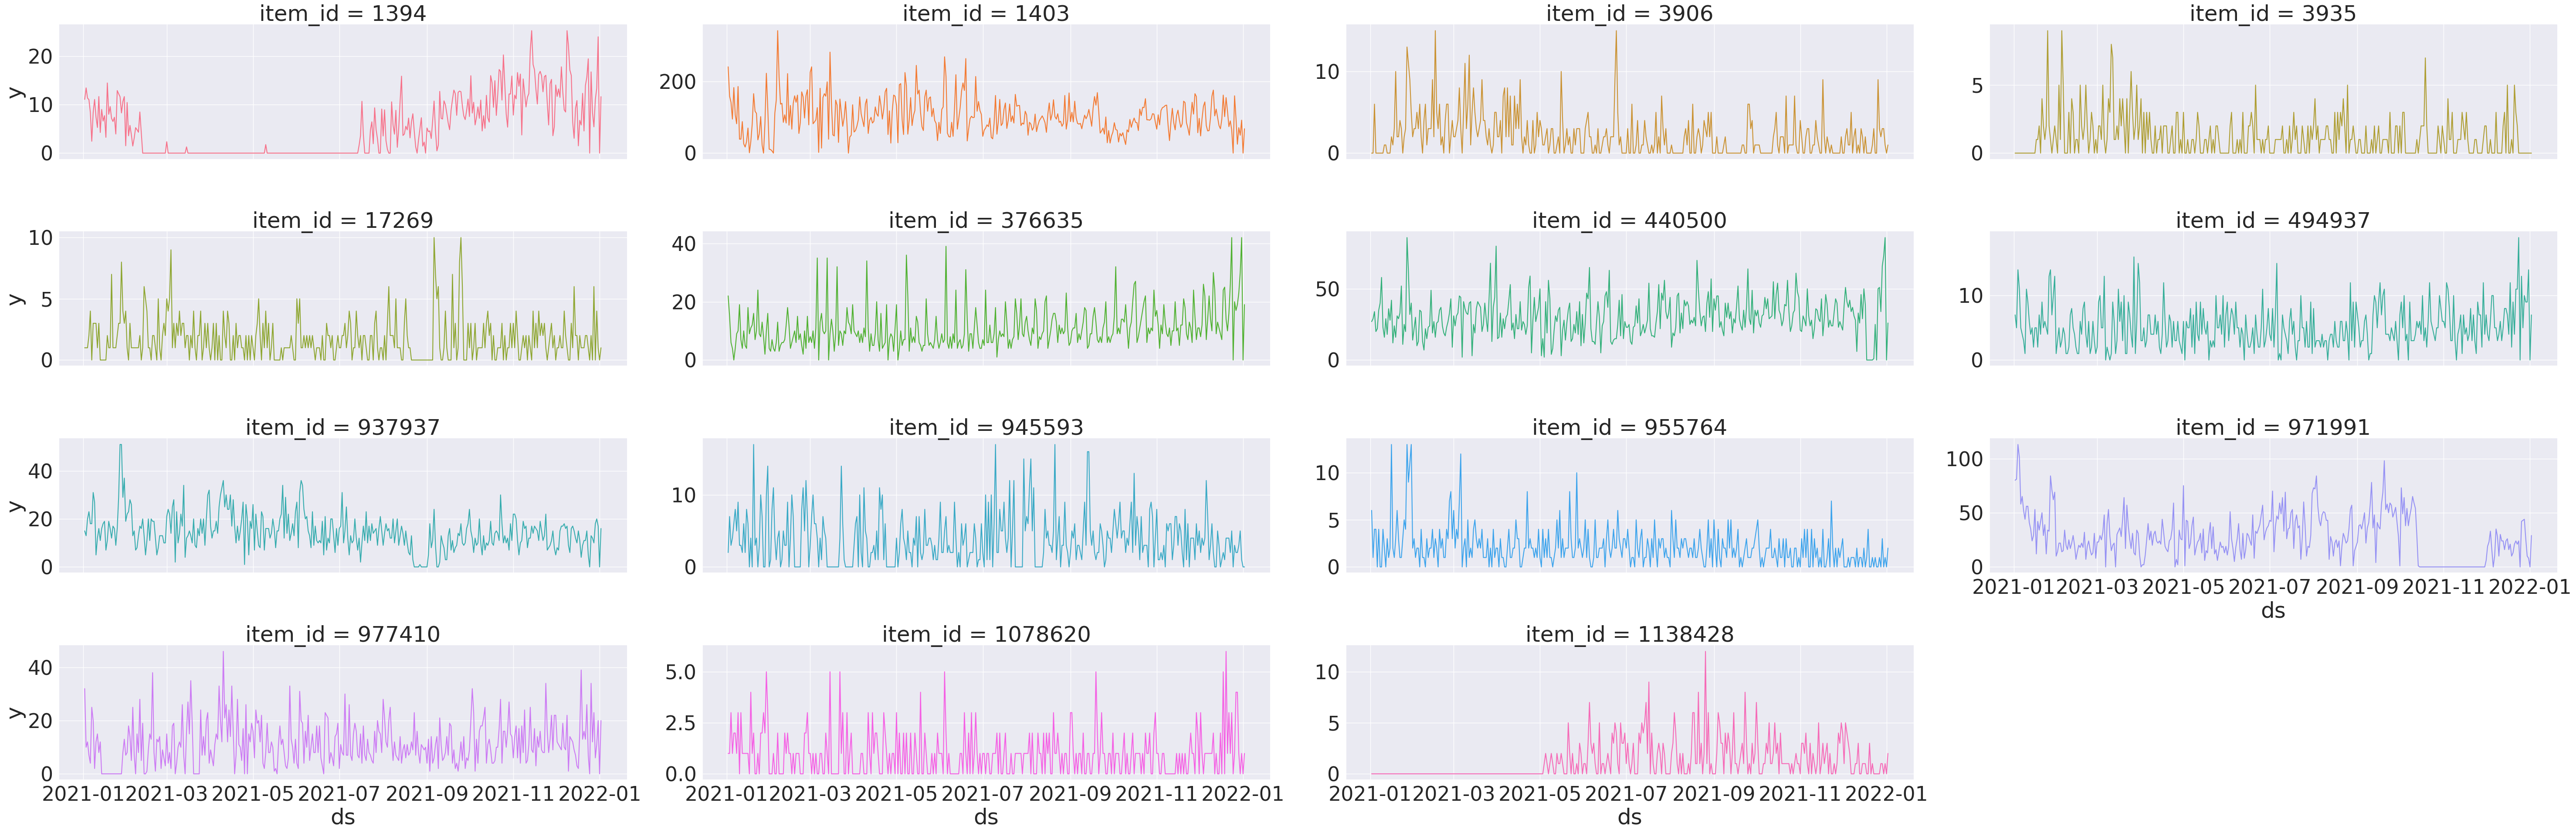

In [12]:
# Graficamos por mes y día el dataset de train
sns.set(font_scale=3) 
g = sns.FacetGrid(df_train, 
                  hue='item_id', 
                  col='item_id', 
                  col_wrap=4,
                  sharey=False,
                  height=5, 
                  aspect=3)
g.map_dataframe(sns.lineplot, x="ds", y="y")

plt.show()

Completamos el dataset de train con los días que faltan ya que nos va a facilitar la comparación cuando tengamos que evaluar las predicciones y guardamos ambos dataframe para utilizarlo en los notebooks posteriores.

In [13]:
# Obtenemos la fecha mínima y máxima del dataset
fecha_minima = df_val['ds'].min()
fecha_maxima = df_val['ds'].max()

# Creamos un rango de fechas completas utilizando range
rango_fechas_completas = pd.date_range(start=fecha_minima, end=fecha_maxima, freq='D')
df_fechas = pd.DataFrame({'ds': rango_fechas_completas})

# Obtenemos las combinaciones únicas de 'hierarchy_2_code' e 'item_id'
combinaciones_unicas = df_val[['hierarchy_2_code', 'item_id']].drop_duplicates()

# Combinación cruzada de las fechas
df_completo = pd.merge(df_fechas, combinaciones_unicas, how='cross')

df_val = df_completo.merge(df_val, on=['ds', 'item_id', 'hierarchy_2_code'], how='left')
df_val.fillna(0, inplace=True)
df_val.head()

,ds,hierarchy_2_code,item_id,y
0,2022-01-03,101,3906,4.0
1,2022-01-03,60,937937,25.0
2,2022-01-03,82,955764,5.0
3,2022-01-03,15,376635,10.0
4,2022-01-03,71,440500,19.0


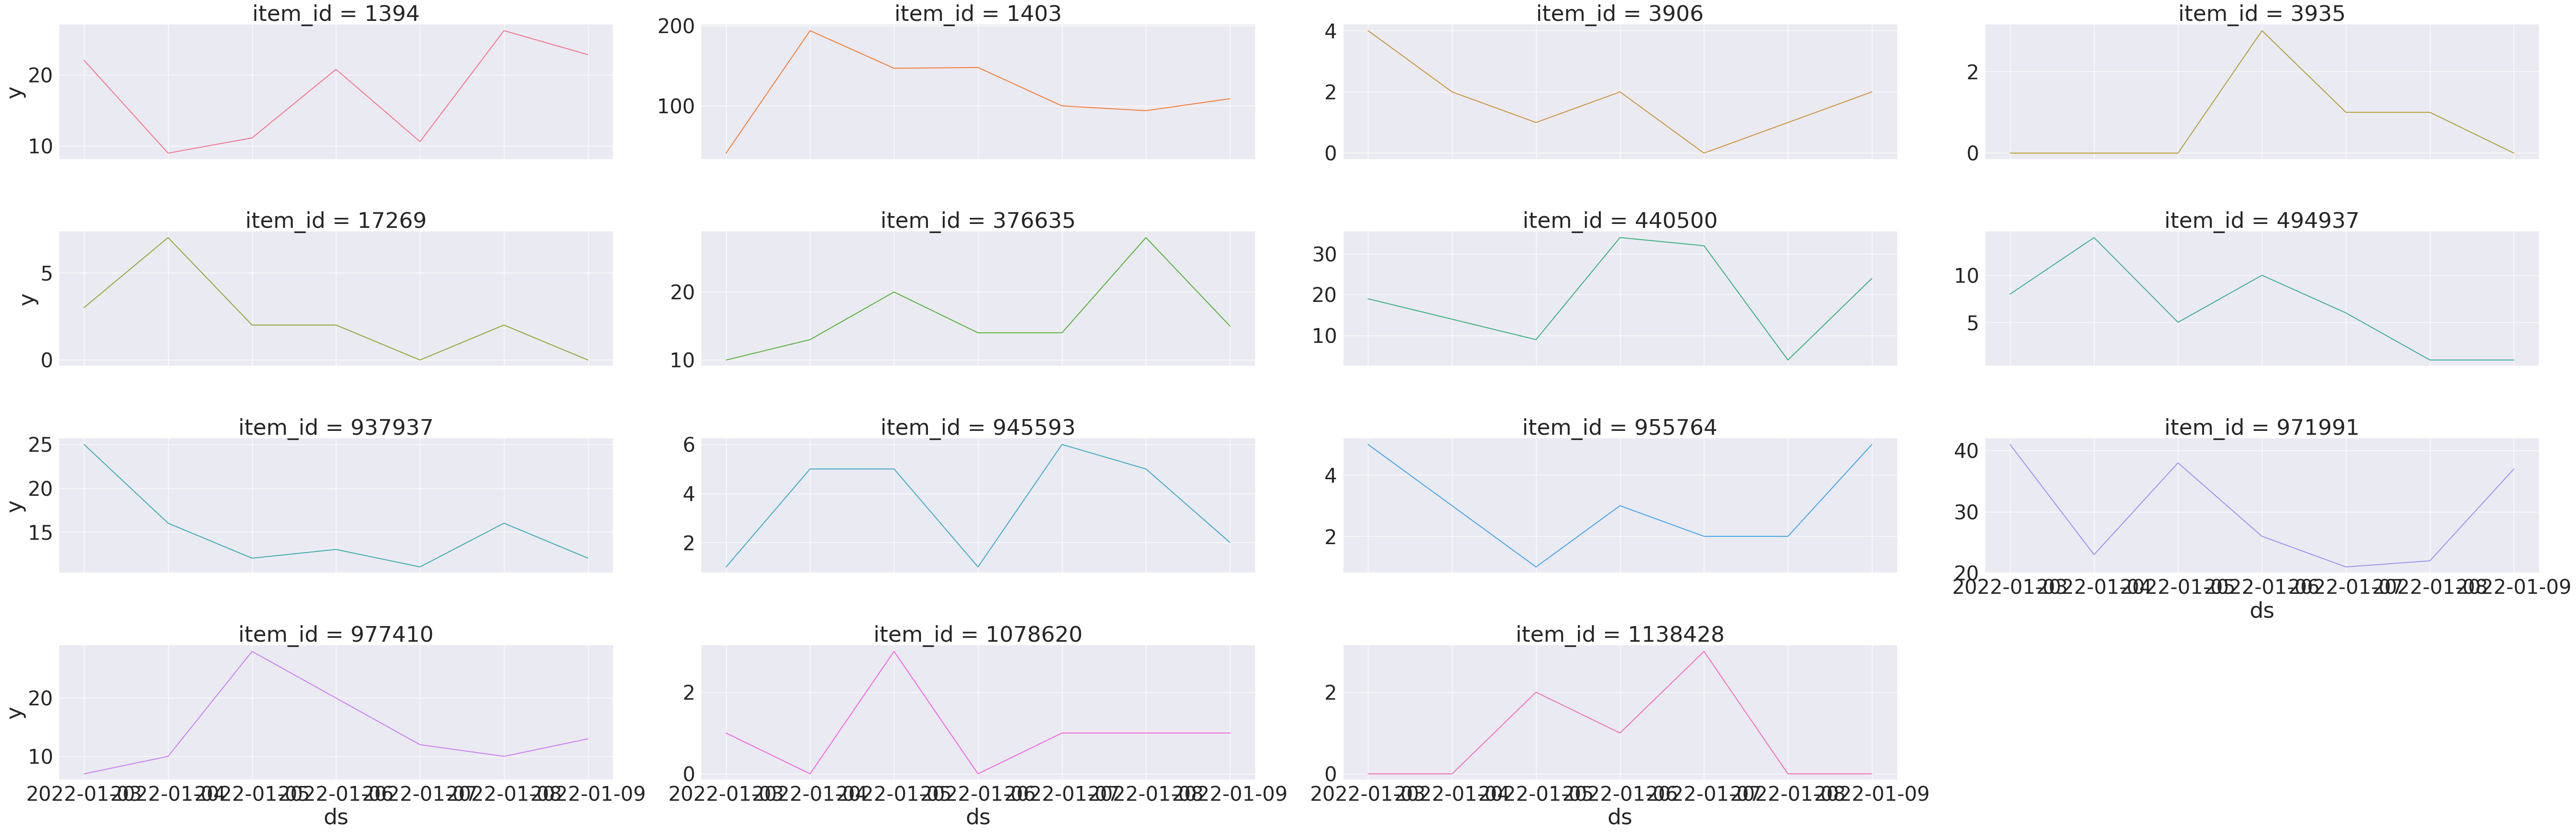

In [14]:
# Graficamos por mes y día
sns.set(font_scale=3) 
g = sns.FacetGrid(df_val, 
                  hue='item_id', 
                  col='item_id', 
                  col_wrap=4,
                  sharey=False,
                  height=5, 
                  aspect=3)
g.map_dataframe(sns.lineplot, x="ds", y="y")

plt.show()

In [15]:
df_train.to_csv('datos_ventas_train_sample.csv',
               index=False)
df_val.to_csv('datos_ventas_validation_sample.csv',
             index=False)

### Métricas de forecasting

Para evaluar un modelo de forecasting, hay varias métricas que pueden utilizarse en función de las características del problema y los objetivos específicos. Describiremos a continuación algunas de ellas:

- Error absoluto medio (Mean Absolute Error, MAE):
El error absoluto medio es la media de las diferencias absolutas entre los valores pronosticados y los valores reales. Mide la magnitud promedio del error sin considerar su dirección. Un valor de MAE más bajo indica una mejor precisión del modelo.

- Error cuadrático medio (Mean Squared Error, MSE):
El error cuadrático medio es la media de las diferencias al cuadrado entre los valores pronosticados y los valores reales. Al elevar al cuadrado las diferencias, se da más peso a los errores grandes. Un valor de MSE más bajo indica una mejor precisión del modelo, pero en comparación con el MAE, el MSE tiene la ventaja de penalizar los errores más grandes de manera más significativa.

- Raíz del error cuadrático medio (Root Mean Squared Error, RMSE):
La raíz del error cuadrático medio es simplemente la raíz cuadrada del MSE. Al calcular la raíz cuadrada, se vuelve a la escala original de la variable objetivo, lo que facilita la interpretación. Un valor de RMSE más bajo indica una mejor precisión del modelo.


Para comparar nuestros modelos y las predicciones de los diferentes items utilizaremnos MAE y RMSE. El MAE es una medida de error que no está tan afectada por la escala de los datos, ya que toma la media de las diferencias absolutas entre los valores pronosticados y los valores reales. Es adecuado para comparar series con diferentes escalas como en este caso que tenemos items con un total de cantidad de ventas muy diverso.

El RMSE también es una medida comúnmente utilizada al estar en la misma escala que los datos originales puede dificultar la comparación directa de series con diferentes escalas. Pero nos permite evaluar la magnitud de la desviación de las predicciones.

In [16]:
# Mean absolute error
def prediction_mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

# Root Mean Square Error
def prediction_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

Estas dos funciones las utilzaremos para comparar las predicciones.